# Data Mining Project

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

account = pd.read_csv('../data/account.csv',delimiter=';')
card_dev = pd.read_csv('../data/card_dev.csv',delimiter=';')
client = pd.read_csv('../data/client.csv',delimiter=';')
disp = pd.read_csv('../data/disp.csv',delimiter=';')
district = pd.read_csv('../data/district.csv',delimiter=';')
loan_dev = pd.read_csv('../data/loan_dev.csv',delimiter=';')
trans_dev = pd.read_csv('../data/trans_dev.csv',delimiter=';', dtype={'bank':'str'})

## Business Understanding

The bank wants to improve their services. For instance, the bank managers have only vague idea, who is a good client (whom to offer some additional services) and who is a bad client (whom to watch carefully to minimize the bank loses). Fortunately, the bank stores data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued. The bank managers hope to improve their understanding of customers and seek specific actions to improve services. A mere application of a discovery tool will not be convincing for them.  

To test a data mining approach to help the bank managers, it was decided to address two problems, a descriptive and a predictive one. While the descriptive problem was left open, the predictive problem is the prediction of whether a loan will end successfuly.

## Data Understanding

### Build Dataset

In [156]:
def parse_date(d):
  year = int(str(d)[0:2])
  month = int(str(d)[2:4])
  day = int(str(d)[4:6])
  return { 'year': year, 'month': month, 'day': day }

In [157]:
def parse_gender(row, birth_date):
  female = birth_date['month'] >= 50

  if female:
    row['gender'] = 'female' 
    birth_date['month'] -= 50
  else:
    row['gender'] = 'male' 

In [158]:
def calculate_age_loan(row):
  date_loan = row['date_loan']
  birth_number = row['birth_number']

  birth_date = parse_date(birth_number)

  parse_gender(row, birth_date)
  
  if (date_loan is None):
    date_loan = parse_date(row['date_loan'])
    date_loan = date_loan['year'] - birth_date['year'] - ((date_loan['month'], date_loan['day']) < (birth_date['month'], birth_date['day']))
  
  row['age_loan'] = date_loan
    
  return row

In [159]:
district["no. of commited crimes '95 "] = pd.to_numeric(district["no. of commited crimes '95 "], errors='coerce')
district["no. of commited crimes '96 "] = pd.to_numeric(district["no. of commited crimes '96 "], errors='coerce')
district["unemploymant rate '95 "] = pd.to_numeric(district["unemploymant rate '95 "], errors='coerce')
district["unemploymant rate '96 "] = pd.to_numeric(district["unemploymant rate '96 "], errors='coerce')

district["no. of commited crimes '95 "] = district["no. of commited crimes '95 "].fillna(0)
district["no. of commited crimes '96 "] = district["no. of commited crimes '96 "].fillna(0)
district["unemploymant rate '95 "] = district["unemploymant rate '95 "].fillna(0)
district["unemploymant rate '96 "] = district["unemploymant rate '96 "].fillna(0)

district['commited_crimes'] = district[['no. of commited crimes \'95 ', 'no. of commited crimes \'96 ']].mean(axis=1)

district = district.drop(["no. of commited crimes '95 ", "no. of commited crimes '96 "], axis= 1).reset_index()

In [160]:
# join account, loan, disposition and client
df = account.merge(loan_dev, on='account_id', suffixes=('','_loan'), how='right')
df = df.merge(disp, on='account_id', suffixes=('','_disp'), how='left')
df = df.merge(client, on='client_id',suffixes=('','_client'), how='left')

df.drop(columns='district_id', axis=1, inplace=True)

# create age_at_loan and gender column
df = df.apply(lambda row: calculate_age_loan(row), axis=1)

# join demograph
district.rename(columns={'code ':'code'}, inplace=True)
df = df.merge(district, left_on='district_id_client', right_on='code', how='left')

# join creditcard
df = df.merge(card_dev, on='disp_id', suffixes=('', '_card'), how='left')

# join transactions
df_transactions = df.merge(trans_dev, on='account_id', suffixes=('', '_transaction'), how='left')

df

,account_id,frequency,date,loan_id,date_loan,amount,duration,payments,status,disp_id,...,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,commited_crimes,card_id,type_card,issued
0,1787,weekly issuance,930322,5314,930705,96396,12,8033,-1,2166,...,10,81.8,9650,3.38,3.67,100,2894.5,NaN,NaN,NaN
1,1801,monthly issuance,930213,5316,930711,165960,36,4610,1,2181,...,10,73.5,8369,1.79,2.31,117,2736.0,NaN,NaN,NaN
2,9188,monthly issuance,930208,6863,930728,127080,60,2118,1,11006,...,5,53.5,8390,2.28,2.89,132,2101.0,NaN,NaN,NaN
3,1843,monthly issuance,930130,5325,930803,105804,36,2939,1,2235,...,9,74.8,10045,1.42,1.71,135,6449.5,NaN,NaN,NaN
4,11013,weekly issuance,930214,7240,930906,274740,60,4579,1,13231,...,5,50.5,8288,3.79,4.52,110,1511.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,9030,monthly issuance,950121,6818,961212,155616,48,3242,1,10814,...,4,62.6,8994,3.80,4.79,110,9440.0,NaN,NaN,NaN
399,3189,monthly issuance,951129,5625,961215,222180,60,3703,-1,3855,...,6,55.6,8843,2.82,3.60,113,853.0,NaN,NaN,NaN
400,8972,monthly issuance,960521,6805,961221,45024,48,938,1,10742,...,7,89.9,10177,6.63,7.75,81,9993.0,NaN,NaN,NaN
401,10963,monthly issuance,950520,7233,961225,115812,36,3217,1,13172,...,8,56.9,8427,1.12,1.54,107,1893.5,NaN,NaN,NaN


### Exploratory Analysis

- número de disponentes vs status 
    - quantas pessoas podem depositar naquela conta / contas quantas aquela pessoa tem ??
- amount da loan vs status 
    - isto tipo não sei se faz super sentido era mais para perceber se o risco aumenta quanto maior for a loan ou se não podems concluir isso
    
- crime rate vs status
- taxa de desemprego vs status
- salário médio da região
- ... outros dados demográficos vs status ??
- diferença salário médio e dinheiro da loan pago a cada mês vs status
    - se o que a pessoa paga em cada mês é quase a totalidade do seu salário, é mais provável que não possa pagar a dada altura
- duration vs status
- género vs status
- frequência com que é utilizada a conta vs status
    - ver pelo número de transactions, no fundo é se é cliente ativo ou não
- percentagem de depósitos/débitos vs status 
    - my thought process foi que se eu só uso a conta para debitar dinheiro secalhar tou a gastar mais do que o ganho kk
- quantas loans tem 'ativas' 
    - ver interseção data de aceitação + duração
- ...


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 402
Data columns (total 35 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   account_id                                         403 non-null    int64  
 1   frequency                                          403 non-null    object 
 2   date                                               403 non-null    int64  
 3   loan_id                                            403 non-null    int64  
 4   date_loan                                          403 non-null    int64  
 5   amount                                             403 non-null    int64  
 6   duration                                           403 non-null    int64  
 7   payments                                           403 non-null    int64  
 8   status                                             403 non-null    int64  
 9   disp_id   

In [162]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30373 entries, 0 to 30372
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   account_id                                         30373 non-null  int64  
 1   frequency                                          30373 non-null  object 
 2   date                                               30373 non-null  int64  
 3   loan_id                                            30373 non-null  int64  
 4   date_loan                                          30373 non-null  int64  
 5   amount                                             30373 non-null  int64  
 6   duration                                           30373 non-null  int64  
 7   payments                                           30373 non-null  int64  
 8   status                                             30373 non-null  int64  
 9   disp_i

Text(0.5, 1.0, 'Status count for bank loans')

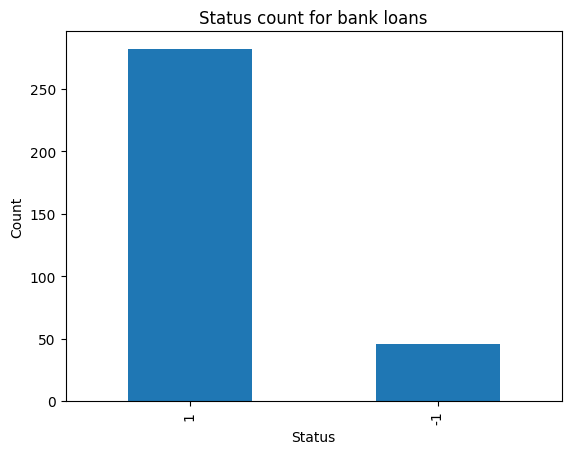

In [163]:
loan_dev['status'].value_counts().plot.bar()
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Status count for bank loans')

<AxesSubplot: title={'center': 'amount'}, xlabel='status'>

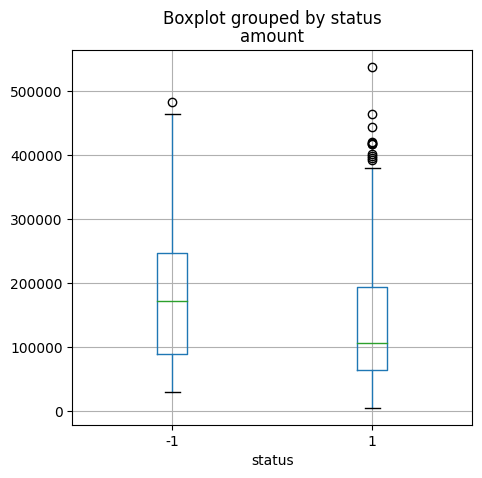

In [164]:
loan_dev.boxplot(column='amount', by='status', figsize=(5,5))

<AxesSubplot: title={'center': 'payments'}, xlabel='status'>

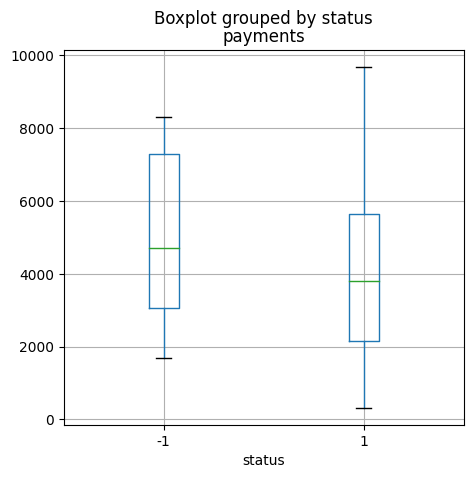

In [165]:
loan_dev.boxplot(column='payments', by='status', figsize=(5,5))

<AxesSubplot: title={'center': 'duration'}, xlabel='status'>

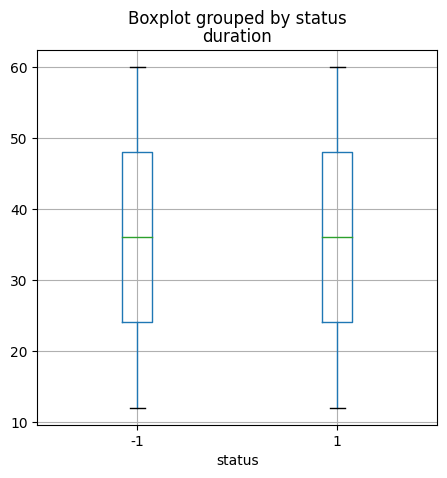

In [166]:
loan_dev.boxplot(column='duration', by='status', figsize=(5,5))


Since the boxes are not totally aligned, there might be a relation between the loan amount and the successfulness of a loan. The higher the amount, the most likely it is to fail. The differences in the graphics aren't, however, significant and our conclusions are enforced by logic.

<AxesSubplot: title={'center': 'age_loan'}, xlabel='status'>

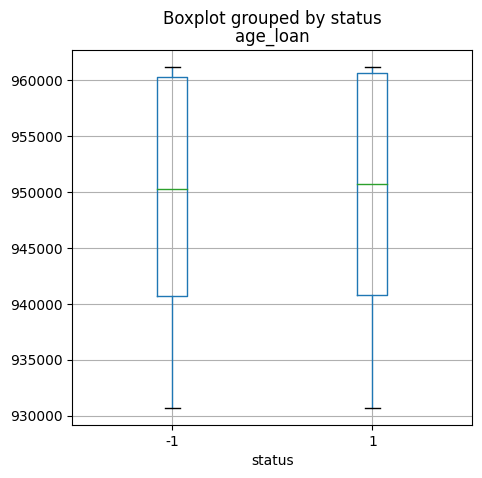

In [167]:
df.boxplot(column='age_loan', by='status', figsize=(5,5))


In [168]:
disp_count = df.groupby(['account_id'])['disp_id'].nunique()
disp_count

account_id
2        2
19       1
67       1
132      2
173      2
        ..
11186    2
11265    1
11349    2
11359    1
11362    1
Name: disp_id, Length: 328, dtype: int64

In [169]:
df = df.merge(disp_count, on='account_id', suffixes=('', '_count'), how='left')


<AxesSubplot: title={'center': 'disp_id_count'}, xlabel='status'>

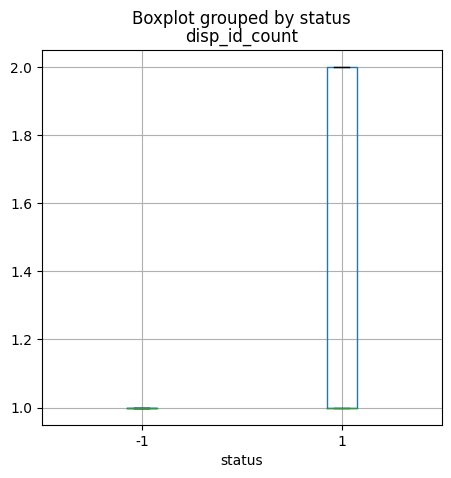

In [170]:
df.boxplot(column='disp_id_count', by='status', figsize=(5,5))

Text(0.5, 1.0, 'Status count by number of account disponents')

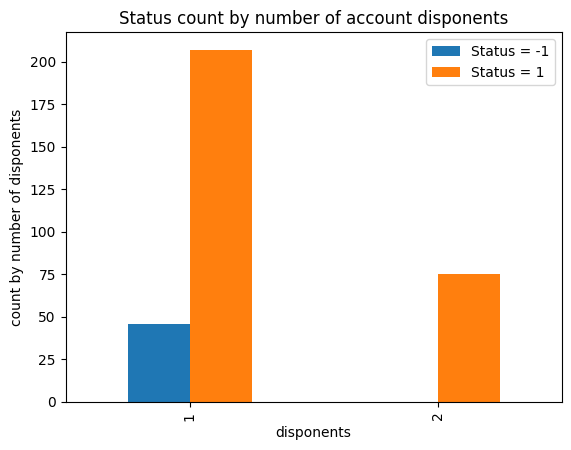

In [171]:
#remove duplicates
no_dups_df = df.drop_duplicates(subset=['account_id'])
no_dups_df.groupby('disp_id_count')['status'].value_counts().unstack(1).plot.bar()

plt.xlabel('disponents')
plt.ylabel('count by number of disponents')
plt.legend(['Status = -1', 'Status = 1'])
plt.title('Status count by number of account disponents')

<AxesSubplot: title={'center': 'average salary '}, xlabel='status'>

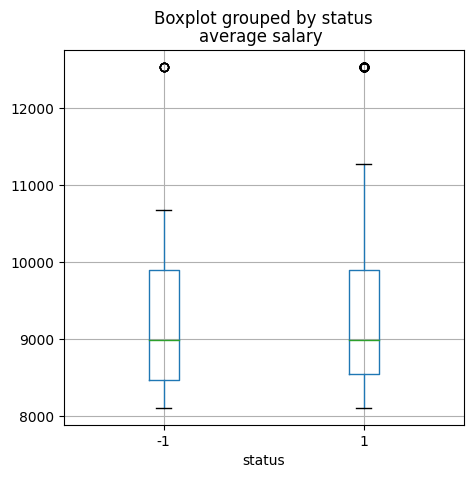

In [172]:
df.boxplot(column='average salary ', by='status', figsize=(5,5))

## Data Preparation

## Model